## Read .ghg metadata

In [3]:
import preProcessing
import importlib
import time
importlib.reload(preProcessing)
T1 = time.time()

# Need one or more metadata templates if working with .dat files
template = ['Y:/BBS/TOA5_BBS.FLUX_2023_06_14_1500.metadata']

copyFrom = "X:\\BBS\\EC_Station\\2023\\20230616"
copyTag = "BBS.FLUX"
pr = preProcessing.read_ALL('BBS',
                            fileType='dat',
                            reset=1,
                            metadataTemplate=template,
                            copyFrom=copyFrom,
                            copyTag=copyTag,
                            timeShift=30)

pr.find_files(2023,6,processes=4)

# updates = 'Y:/BB/Metadata_Updates.csv'
# pr = preProcessing.read_ALL('BB',fileType='ghg',metadataUpdates=updates,reset=1)
# # If updates/corrections must be made to metadata (e.g., undocumented orientation changes) a .csv files of updates can be provided

# for y in range(2015,2024):
#     for m in range(1,13):
#         pr.find_files(y,m)

# T2 = time.time()

# print('\n')
# print('Runtime: ',(T2-T1)/60,' minutes')


Deleting all contents of: C:/temp/EP_API_Testing/BBS/metadata/
Copying Metadata file:
 Y:/BBS/TOA5_BBS.FLUX_2023_06_14_1500.metadata
Copying Files [████████████████████████████████████████████████████████████] 94/94

Starting fresh run
Preprocessing 2023 06[████████████████████████████████████████████████████████████] 92/92

['instr_1_height', 'instr_1_north_offset', 'instr_2_tube_length', 'instr_2_tube_diameter', 'instr_2_northward_separation', 'instr_2_eastward_separation', 'instr_2_vertical_separation']


In [2]:
# ## Implement pre-processing procedures to exclude data by conditions (e.g., low flow rate)
pr.ini['dat']
# import numpy as np
# pr.dataRecords['flow_rate_7200']
# pr.dataRecords.loc[pr.dataRecords['flow_rate_7200'].abs()>1e2,'flow_rate_7200']=np.nan
# pr.dataRecords['flow_rate_7200'].plot()
# # pr.dataRecords['col_air_t'].plot()#['altitude'].describe()
# 317/60

{'search': '([0-9]{4}\\_[0-9]{2}\\_[0-9]{2}\\_[0-9]{4})',
 'format': '%Y_%m_%d_%H%M',
 'ep_date_pattern': 'yyyy_mm_dd_HHMM'}

In [2]:
# https://www.licor.com/env/support/EddyPro/topics/low-pass-filtering.html

hf_corrections = {
    'Moncrieff et al. (1997)':1,
    'Horst (1997)':2,
    'brom et al. (2007)':3,
    'Fratini et al. (2012)':4, # Recommended , when sufficient data (>1 month) are available
    'Massman (2000, 2001)':5
}

# bin_sp_avail=[0,1]
# full_sp_avail=[0,1]
# sa_bin_spectra='Path'
# sa_full_spectra = 'Path'

In [3]:
## To DO: Add Output ID on merge so we can trace down specific thread/log file for a given run
## Same timestamp can have different outputs depending on batch it was run in
## Usually minor differences, but can be larger in select circumstances

import setupEP as eP
import importlib
import time
importlib.reload(eP)

########## Note - incomplete ghg or biomet files can crash program (preprocessing procedures should help prevent that by re-naming incomplete files)

T1 = time.time()
# mR = eP.makeRun('ep_Templates/DefaultSettings.eddypro','BBS',Processes=6,priority = 'high priority')
# mR.runDates(['2023-01-01 00:00','2024-03-31 23:59'])

mR = eP.makeRun('ep_Templates/LabStandard_Advanced.eddypro','BB',Processes=4,priority = 'high priority')
mR.updateTemplate({'FluxCorrection_SpectralAnalysis_General':
                    {'sa_mode':4}
                })
# mR.runDates(['2015-01-01 00:00','2023-12-31 23:59'])

T2 = time.time()
print('\n')
print('Runtime: ',(T2-T1)/60)



Runtime:  0.0007286032040913899


## Full Runtime

### Reading & Writing all to Y: drive:

1 Month of BB data (20 hz)

**Preprocessing**: 3.91 minutes (8 cores)
**Processing**: 56.92 minutes (6 cores)

Total: **60.83** minutes

### Reading & Preprocessing on Y: drive then writing EddyPro results locally:

1 Month of BB data (20 hz)

**Preprocessing**: 3.91 minutes (8 cores)
**Processing**: 55.74 minutes (6 cores)

Total: **59.65** minutes

### Copying data to C then writing EddyPro results locally:

1 Month of BB data (20 hz)

**Preprocessing**: 6.30 minutes (1 core copy > 8 core preprocessing)

**Processing**: 54.33 minutes (6 cores)

Total: **60.3** minutes

* Paralellizing data copy could shave enought time to get marginal benfit, but doesn't look to matter much

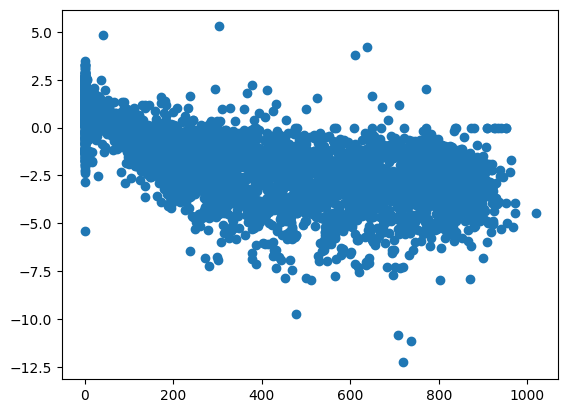

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(mR.all_outputs['fulloutput'],skiprows=[0,2],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')
# Add routine to handle duplicates (or find rood cause of them )
# Occuring on boundary between batches I assume as there are ~ 2x as many duplicates as batches
df = df.loc[df.index.duplicated()==False].copy()

bm = pd.read_csv(mR.all_outputs['biomet'],skiprows=[1],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')
bm = bm.loc[bm.index.duplicated()==False].copy()


df = pd.concat([df,bm[bm.columns[~bm.columns.isin(df.columns)]]],axis=1)
df.loc[df['qc_co2_flux']>0,'co2_flux']=np.nan
df.loc[df['u*']<0.15,'co2_flux']=np.nan

plt.scatter(df['Rg_1_1_1'],df['co2_flux'])

# df.loc[df['co2_flux']>20,['wind_speed','u*','wind_dir','Ta_1_1_1','H']]


In [59]:
# df.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
# bm.duplicated().sum()
# bm.columns[bm.columns.duplicated()]
# T1 = df.iloc[0:10].copy()
# T2 = bm[bm.columns[~bm.columns.isin(df.columns)]].iloc[0:10].copy()


# T3 = pd.concat([T1,T2],axis=1)
# T3
rep = df[df.index.duplicated(keep=False)].sort_index().copy()#.duplicated()#['co2_flux']
# print(rep.shape)
for c in rep.columns:
    s = rep.loc[rep[c].duplicated(keep=False)==False,c]

    if s.shape[0]>1:
        # print(c)
        # print(s.shape[0])
        print(rep[['filename',c]].groupby('filename').diff().dropna().min())
        print()

Tau   -0.000023
dtype: float64

H   -1.585
dtype: float64

LE   -14.732
dtype: float64

co2_flux   -0.41233
dtype: float64

h2o_flux   -0.33465
dtype: float64

ch4_flux   -0.000021
dtype: float64

H_strg   -0.0003
dtype: float64

LE_strg   -0.00124
dtype: float64

co2_strg   -0.00027
dtype: float64

h2o_strg   -0.000028
dtype: float64

ch4_strg    0.0
dtype: float64

co2_v-adv   -4.000000e-16
dtype: float64

h2o_v-adv   -2.300000e-15
dtype: float64

ch4_v-adv    0.0
dtype: float64

co2_molar_density   -0.0001
dtype: float64

co2_mole_fraction   -0.002
dtype: float64

co2_mixing_ratio   -0.002
dtype: float64

co2_time_lag   -0.3
dtype: float64

h2o_molar_density   -0.091
dtype: float64

h2o_mole_fraction   -0.0022
dtype: float64

h2o_mixing_ratio   -0.0023
dtype: float64

ch4_molar_density    0.0
dtype: float64

ch4_mole_fraction    0.0
dtype: float64

ch4_mixing_ratio    0.0
dtype: float64

ch4_time_lag    0.0
dtype: float64

air_density   -0.00014
dtype: float64

air_heat_capacity   -

H_scf   -0.00001
dtype: float64

un_LE   -10.3188
dtype: float64

LE_scf   -0.14099
dtype: float64

un_co2_flux   -0.07376
dtype: float64

co2_scf   -0.19366
dtype: float64

un_h2o_flux   -0.233327
dtype: float64

h2o_scf   -0.14099
dtype: float64

un_ch4_flux    0.0
dtype: float64

ch4_scf    0.0
dtype: float64

amplitude_resolution_hf   -90.0
dtype: float64

skewness_kurtosis_hf   -90.0
dtype: float64

skewness_kurtosis_sf   -90.0
dtype: float64

no_signal_LI-7700   -36000.0
dtype: float64

top_heater_on_LI-7700   -36000.0
dtype: float64

bottom_heater_on_LI-7700   -36000.0
dtype: float64

co2_var   -0.027
dtype: float64

h2o_var   -0.000418
dtype: float64

ch4_var    0.0
dtype: float64

w/co2_cov   -0.001788
dtype: float64

w/h2o_cov   -0.005705
dtype: float64

w/ch4_cov    0.0
dtype: float64

co2_mean_alt   -0.001
dtype: float64

ch4_mean    0.0
dtype: float64

air_t_mean    0.0
dtype: float64

air_p_mean    0.0
dtype: float64

rssi_77_mean    0.0
dtype: float64



In [50]:
rep.columns

Index(['filename', 'DOY', 'daytime', 'file_records', 'used_records', 'Tau',
       'qc_Tau', 'H', 'qc_H', 'LE',
       ...
       'air_t_mean', 'air_p_mean', 'rssi_77_mean', 'Unnamed: 162',
       'vin_sf_mean', 'h2o_mean_alt', 'dew_point_mean', 'hit_power_mean',
       'hit_vin_mean', 'air_p_mean_alt'],
      dtype='object', length=167)

,LE_fratini,LE_moncrieff,co2_flux_fratini,co2_flux_moncrieff,ch4_flux_fratini,ch4_flux_moncrieff
count,542.000,542.000,543.000,543.000,374.000,361.000
mean,152.558,93.803,-3.149,-2.969,0.072,0.065
std,95.642,67.008,1.691,1.584,0.020,0.018
min,2.387,1.310,-6.908,-6.401,-0.041,-0.048
25%,70.863,34.734,-4.341,-4.072,0.059,0.053
50%,147.756,84.936,-3.376,-3.099,0.071,0.064
75%,234.345,145.632,-2.143,-2.288,0.086,0.077
max,353.413,304.631,2.777,2.618,0.157,0.144


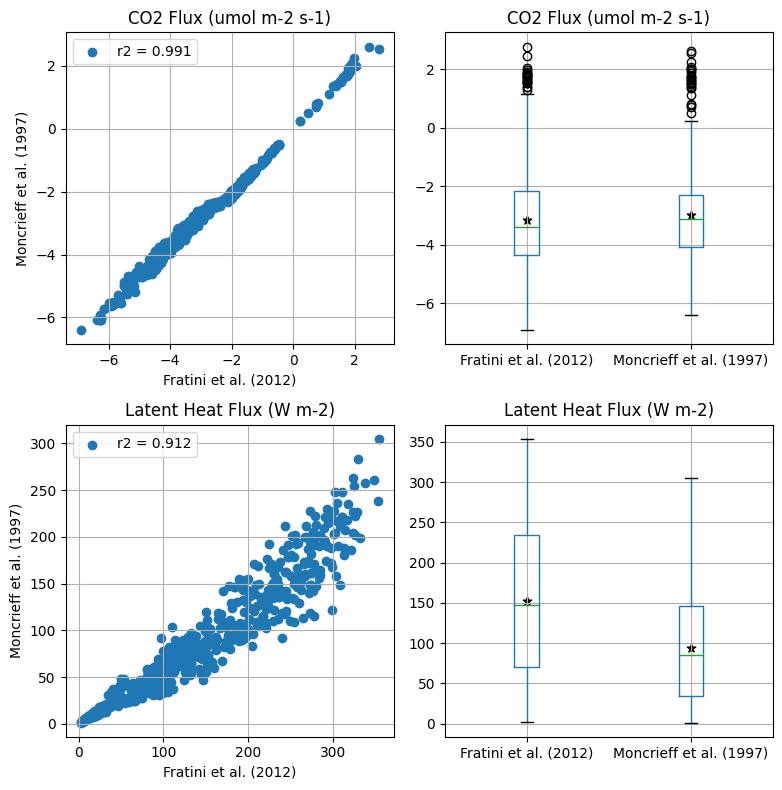

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
monc = 'Y:\\BB\\Spectral_Comp\\Moncrieff/'+'eddypro_BB_20230601_20230630_full_output_2024-03-15T153700_adv.csv'
frat = 'Y:\\BB\\Spectral_Comp\\Fratini/'+'eddypro_Spectral_Correction_fratini_full_output_2024-03-19T000447_adv.csv'
df_fratini = pd.read_csv(frat,skiprows=[0,2],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')
df_moncrieff = pd.read_csv(monc,skiprows=[0,2],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')

def Filt(df):
    df['filt'] = 1
    df.loc[df['u*']<.15,'filt']=np.nan
    df.loc[df['qc_co2_flux']>0,'filt']=np.nan
    df.loc[df['qc_LE']>0,'filt']=np.nan
    return(df)

df_fratini = Filt(df_fratini)
df_moncrieff = Filt(df_moncrieff)


# df_fratini=df_fratini.loc[df_fratini.index.month==6].copy()

cols = ['filt','u*','co2_flux','qc_co2_flux','LE','qc_LE','H','qc_H','ch4_flux','qc_ch4_flux']
frat_cols = {key: key+'_fratini' for key in cols}
monc_cols = {key: key+'_moncrieff' for key in cols}

df_fratini = df_fratini[cols].rename(columns=frat_cols)
df_moncrieff = df_moncrieff[cols].rename(columns=monc_cols)

df = df_fratini.join(df_moncrieff)

df['filt']=df['filt_fratini']*df['filt_moncrieff']

for col in df.columns:
    if col !='filt':
        df[col]=df[col]*df['filt']


fig,ax=plt.subplots(2,2,figsize=(8,8))


ax[0,0].scatter(df['co2_flux_fratini'],df['co2_flux_moncrieff'],label=f"r2 = {(df[['co2_flux_fratini','co2_flux_moncrieff']].corr()**2)['co2_flux_moncrieff'].round(3).values[0]}")
ax[0,0].set_xlabel('Fratini et al. (2012)')
ax[0,0].set_ylabel('Moncrieff et al. (1997)')
ax[0,0].set_title('CO2 Flux (umol m-2 s-1)')
ax[0,0].legend()
ax[0,0].grid()

df[['co2_flux_fratini','co2_flux_moncrieff']].boxplot(ax=ax[0,1])
ax[0,1].scatter([1,2],df[['co2_flux_fratini','co2_flux_moncrieff']].mean().values,marker='*',s=40,color='k')
ax[0,1].set_xticklabels(['Fratini et al. (2012)','Moncrieff et al. (1997)'])
ax[0,1].set_title('CO2 Flux (umol m-2 s-1)')


ax[1,0].scatter(df['LE_fratini'],df['LE_moncrieff'],label=f"r2 = {(df[['LE_fratini','LE_moncrieff']].corr()**2)['LE_moncrieff'].round(3).values[0]}")
ax[1,0].set_xlabel('Fratini et al. (2012)')
ax[1,0].set_ylabel('Moncrieff et al. (1997)')
ax[1,0].set_title('Latent Heat Flux (W m-2)')
ax[1,0].legend()
ax[1,0].grid()

df[['LE_fratini','LE_moncrieff']].boxplot(ax=ax[1,1])
ax[1,1].scatter([1,2],df[['LE_fratini','LE_moncrieff']].mean().values,marker='*',s=40,color='k')
ax[1,1].set_xticklabels(['Fratini et al. (2012)','Moncrieff et al. (1997)'])
ax[1,1].set_title('Latent Heat Flux (W m-2)')

plt.tight_layout()


df[['LE_fratini','LE_moncrieff','co2_flux_fratini','co2_flux_moncrieff','ch4_flux_fratini','ch4_flux_moncrieff',]].describe().round(3)

# Speedtests

All times in minutes

### 4 threads (8 timesteps each)

Normal priority: 2.05
High priority: 1.91

### 4 threads (48 timesteps each x 12 days)

High priority: 29

### Eddypro GUI (1 run [12 days, 576 timesteps])

High priority: 90